## **Evaluation of Fine-Tuned Model on HumanEval Benchmark**

This notebook compares the performance of the **Base Model (StarCoderBase-1B)** against our **Fine-Tuned (PEFT)** variant, titled **"StarPilot-1B"**, using the **BigCode Evaluation Harness**. We utilize **HumanEval**, a benchmark of 164 Python problems, to measure functional correctness.

**Key Metrics:**
* **Pass@1:** The percentage of problems where the model's *first* generation passes all unit tests.
* **Pass@10:** The probability that *at least one* correct solution exists in the top 10 generations.

##### Environment Setup
We mount google drive, login to hugging face, install the necessary dependencies and clone the harness repository to access the scripts required for HumanEval benchmark.

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Change Path
%cd /content/drive/MyDrive/Sahil/Fine-Tuning

Mounted at /content/drive
/content/drive/MyDrive/Sahil/Fine-Tuning


In [3]:
# Hugging Face Login
from huggingface_hub import notebook_login
notebook_login()

In [4]:
# Install core libraries
!pip install -q transformers accelerate bitsandbytes datasets peft

# Clone and install the BigCode Evaluation Harness
!git clone https://github.com/bigcode-project/bigcode-evaluation-harness.git
!pip install -q -r bigcode-evaluation-harness/requirements.txt
!pip install -q -e bigcode-evaluation-harness

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 39.4 MB/s eta 0:00:00
Cloning into 'bigcode-evaluation-harness'...
remote: Enumerating objects: 4362, done.
remote: Counting objects: 100% (1290/1290), done.
remote: Compressing objects: 100% (696/696), done.
remote: Total 4362 (delta 618), reused 594 (delta 594), pack-reused 3072 (from 2)
Receiving objects: 100% (4362/4362), 922.47 KiB | 1.85 MiB/s, done.
Resolving deltas: 100% (3006/3006), done.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


##### Model Configuration
Here we define the paths for the pre-trained base model `starcoderbase-1b` and our fine-tuned adapter.

In [5]:
# Imports
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# Configuration
BASE_MODEL_ID = "bigcode/starcoderbase-1b"
PEFT_ADAPTER_ID = "starpilot-1b-v1"

print(f"Base Model: {BASE_MODEL_ID}")
print(f"Adapter: {PEFT_ADAPTER_ID}")

Base Model: bigcode/starcoderbase-1b
Adapter: starpilot-1b-v1


##### HumanEval Benchmark
Here we execute the quantitative evaluation using the BigCode Harness. It generates code samples from both the base and fine-tuned models against the HumanEval dataset (164 programming problems) and executes them in a sandboxed environment to verify correctness (Pass@k)

In [6]:
# Imports
import json
import os

In [7]:
# Configuration
N_SAMPLES = 10
BATCH_SIZE = 10
MAX_LENGTH = 512
TEMPERATURE = 0.2

In [8]:
# Evaluate Base Model
print(f"\nEvaluating BASE MODEL: {BASE_MODEL_ID}")
!accelerate launch bigcode-evaluation-harness/main.py \
  --model {BASE_MODEL_ID} \
  --tasks humaneval \
  --max_length_generation {MAX_LENGTH} \
  --temperature {TEMPERATURE} \
  --do_sample True \
  --n_samples {N_SAMPLES} \
  --batch_size {BATCH_SIZE} \
  --allow_code_execution \
  --save_generations \
  --save_generations_path "evaluation-results/generations/generations_base.json" \
  --metric_output_path "evaluation-results/metrics/metrics_base.json" \
  --use_auth_token \
  --trust_remote_code


Evaluating BASE MODEL: bigcode/starcoderbase-1b
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2026-01-20 12:48:28.129426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768913308.151803    5749 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768913308.158549    5749 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000

In [9]:
# Evaluate Fine-Tuned Model
print(f"\nEvaluating FINE-TUNED MODEL: {PEFT_ADAPTER_ID}")
!accelerate launch bigcode-evaluation-harness/main.py \
  --model {BASE_MODEL_ID} \
  --peft_model {PEFT_ADAPTER_ID} \
  --tasks humaneval \
  --max_length_generation {MAX_LENGTH} \
  --temperature {TEMPERATURE} \
  --do_sample True \
  --n_samples {N_SAMPLES} \
  --batch_size {BATCH_SIZE} \
  --allow_code_execution \
  --save_generations \
  --save_generations_path "evaluation-results/generations/generations_tuned.json" \
  --metric_output_path "evaluation-results/metrics/metrics_tuned.json" \
  --use_auth_token \
  --trust_remote_code


Evaluating FINE-TUNED MODEL: starpilot-1b-v1
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2026-01-20 12:59:18.923817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768913958.945388   70410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768913958.952000   70410 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00

##### Performance Comparison & Visualization
We parse the JSON results from the harness to calculate Pass@1 and Pass@10 scores. We then visualize these metrics using a grouped bar chart

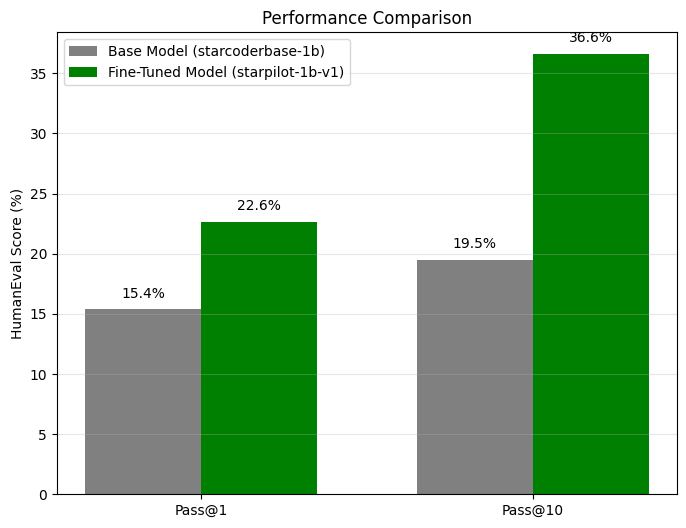

In [10]:
# Imports
import json
import matplotlib.pyplot as plt
import numpy as np

# Load Data
def get_metrics(filename):
    try:
        with open(filename, 'r') as f:
            data = json.load(f)
            p1 = data.get('humaneval', {}).get('pass@1', 0) * 100
            p10 = data.get('humaneval', {}).get('pass@10', 0) * 100
            return [p1, p10]
    except FileNotFoundError:
        print(f"File {filename} not found.")
        return [0, 0]

# Get scores: [Pass@1, Pass@10]
base_scores = get_metrics("evaluation-results/metrics/metrics_base.json")
tuned_scores = get_metrics("evaluation-results/metrics/metrics_tuned.json")

# Plotting
labels = ['Pass@1', 'Pass@10']
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, base_scores, width, label='Base Model (starcoderbase-1b)', color='grey')
plt.bar(x + width/2, tuned_scores, width, label='Fine-Tuned Model (starpilot-1b-v1)', color='green')
plt.ylabel('HumanEval Score (%)')
plt.title('Performance Comparison')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add numbers on top
for i, val in enumerate(base_scores):
    plt.text(i - width/2, val + 1, f"{val:.1f}%", ha='center')
for i, val in enumerate(tuned_scores):
    plt.text(i + width/2, val + 1, f"{val:.1f}%", ha='center')

plt.savefig("evaluation-results/comparison.png")
plt.show()